In [1]:
import datetime
from datetime import datetime
import random
import calendar
import time
import sklearn
import statsmodels.api as sm
import pandas as pd 
from matplotlib.lines import Line2D
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import matplotlib.ticker as mtick
import matplotlib.collections as collections
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn import linear_model, datasets, preprocessing
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from scipy import stats
from copy import deepcopy
from datetime import datetime
from WindPy import w
from numpy import linalg
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

209 209 209 209


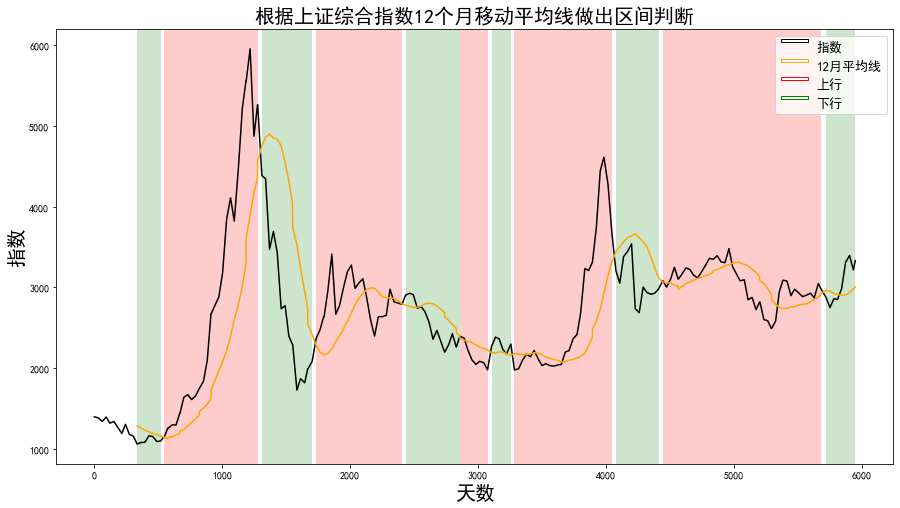

In [2]:
int_list = [['M0020188','股票'],['S0105896','商品'],['M1004271','10债'],['M1004263','1债']]

#起止时间
t0 = '2004-06-01'
t1 = '2020-10-01'

#指数取值周期
dic = {'D':'天', 'W':'周', 'M':'月', 'Q':'季度', 'S':'半年', 'Y':'年'}
prd = 'M'

#利用当前时间prdit前连续itv个周期的数据
itv, prdit = 12, 1

ind_list = []
for i in int_list:
    ind_list.append(i[0])

df = w.wsd(ind_list, 'close', t0, '-1D', Period = prd, Fill = 'Previous')

#指数与日期
data = df.Data
date = df.Times

#斜率判断
sl = 0

#平滑区间
c_s = 4

#最短变化间隔
cd = 2

ind_list = []
for i in int_list:
    ind_list.append(i[0])

d = w.wsd(ind_list, 'close', t0, '-1D', Period = prd, Fill = 'Previous')

data = d.Data
date = d.Times


pro_df = []
origin = 0

for i in range(len(date) - itv - prdit + 2):
    temp = []
    for j in range(len(data)):

        #value指数
        if origin == 1:
            temp.append(data[j][i + itv + prdit - 1])

        df = data[j][i:i+itv]
        
        #average平均值
        temp.append(sum(df)/itv)

        #spike反转数
        spike = 0
        dirc = -(-1) ** (df[1] > df[0]) 
        for k in range(1,itv-1):
            spike += (-(-1) ** (df[k+1] > df[k]) != dirc)
            dirc = -(-1) ** (df[k+1] > df[k])
        temp.append(spike)

        #slope涨幅
        temp.append((df[-1]/df[0])-1)
        

        #height极值差距
        temp.append(max(df)-min(df))

        #direction头尾方向
        temp.append(-(-1) ** (df[-1] > df[0]))
        
        #短期方向
        temp.append(-(-1) ** (df[-1] > df[-2]))

    pro_df.append(temp)

pro_df = pro_df[:-1]
sh = data[0]
nh = data[1]
z10 = data[2]
z1 = data[3]
d8 = date

mage = [i[0] for i in pro_df]

d8i = []
for i in range(len(d8)):
    d8i.append(int((d8[i] - d8[0]).days))
    
    
    
#判断移动平均线
print(len(d8i[itv:]), len(mage), len([i[2] for i in pro_df]),len(sh[itv:]))

#大小关系
comp = [-(-1) ** (mage[i] >= (sh[itv:])[i]) for i in range(len(mage))]

#移动平均线和指数方向
mage_slope = [-(-1) ** (mage[i]/mage[i-1]-1>0) for i in range(1,len(mage))]
mage_slope.insert(0,-comp[0])
df_slope = [i[5] for i in pro_df]

res = [-comp[0]]

c = 0

for i in range(1,len(comp)):
    if comp[i] * comp[i-1] == -1 and c == 0:
        res.append(df_slope[i])
        c += cd
    else:
        res.append(res[-1])
        c = max(0,c-1)
        
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))

ax.set_title('根据上证综合指数'+str(itv)+'个'+str(dic[prd])
             +'移动平均线做出区间判断'
             ,fontproperties='SimHei', size = 20)
ax.plot(d8i,sh, linewidth = 1.5, c = 'black', label = '指数')
ax.plot(d8i[itv:],mage, c = 'orange',label = str(itv)+'月平均线')
plt.xlabel(u'天数',fontproperties='SimHei',fontsize = 20)
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8i[itv:], ymin=0, ymax=max(sh)*1.5, where=np.array(res) == 1, facecolor='r', alpha=.2, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8i[itv:], ymin=0, ymax=max(sh)*1.5, where=np.array(res) == -1, facecolor='green', alpha=.2, label = '下行')
ax.add_collection(collection)

new_legends = ["-", "-", "-", '-']
markers = ['-', '-','-', '-']
colors = ['black', 'orange', 'r', 'green']

_, labels = ax.get_legend_handles_labels()

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)